In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np 
%matplotlib inline
%config InlineBackend.figure_format='retina'
from scipy.stats import norm
from matplotlib import colors

# Predicting gender pay gap from quartile data
The UK Gender Pay Gap data includes the following fields [gov.uk requirements](https://www.gov.uk/guidance/gender-pay-gap-reporting-make-your-calculations#gender-pay-gap-quartile-figures-you-must-calculate):
1. The classic gender pay gap variables being pay for women as a % of pay for men
* `DiffMeanHourlyPercent`
* `DiffMedianHourlyPercent`
2. The same but for bonus, with the percentage of men and women getting bonuses as an additional data point
* `DiffMeanBonusPercent`, `DiffMedianBonusPercent`, `MaleBonusPercent`, `FemaleBonusPercent`
3. The skew between genders by quartile (this is _what percentage of the employees are male or female_ in this quartile, for **full-pay employees**)
* `MaleLowerQuartile`,  `FemaleLowerQuartile`, `MaleLowerMiddleQuartile`, `FemaleLowerMiddleQuartile`, `MaleUpperMiddleQuartile`, `FemaleUpperMiddleQuartile`, `MaleTopQuartile`, `FemaleTopQuartile`

**What about the fact that people on Maternity Pay that aren't getting full pay are excluded from these figures?**

There is data for 2017, 2018 and partial data for 2019.


In [3]:
df1 = pd.read_csv('data/gender-pay-gap-uk-gov/2017.csv.gz',  compression='gzip')
df2 = pd.read_csv('data/gender-pay-gap-uk-gov/2018.csv.gz',  compression='gzip')
df3 = pd.read_csv('data/gender-pay-gap-uk-gov/2019.csv.gz',  compression='gzip')
df1['year'] = 2017
df2['year'] = 2018
df3['year'] = 2019
df = pd.concat([df1, df2, df3])
del df1, df2, df3
df['DiffMeanHourlyPercent'] = df['DiffMeanHourlyPercent'].astype(np.float32)
df['DiffMedianHourlyPercent'] = df['DiffMedianHourlyPercent'].astype(np.float32)
df['DiffMeanBonusPercent'] = df['DiffMeanBonusPercent'].astype(np.float32)
df['DiffMedianBonusPercent'] = df['DiffMedianBonusPercent'].astype(np.float32)
df['FemaleBonusPercent'] = df['FemaleBonusPercent'].astype(np.float32)
df['MaleBonusPercent'] = df['MaleBonusPercent'].astype(np.float32)

df.dropna(subset = {'DiffMeanHourlyPercent', 'DiffMedianHourlyPercent', 'DiffMeanBonusPercent'})
df[['CurrentName', 'year', 'DiffMeanHourlyPercent', 'DiffMedianHourlyPercent', 'DiffMeanBonusPercent']].head(5)

,CurrentName,year,DiffMeanHourlyPercent,DiffMedianHourlyPercent,DiffMeanBonusPercent
0,BRYANSTON SCHOOL INCORPORATED,2017,18.0,28.200001,0.000000
1,"""RED BAND"" CHEMICAL COMPANY, LIMITED",2017,2.3,-2.700000,15.000000
2,118 LIMITED,2017,1.7,2.800000,13.100000
3,123 EMPLOYEES LTD,2017,41.0,36.000000,-69.800003
4,1610 LIMITED,2017,-22.0,-34.000000,-47.000000


In [4]:
# Do more men than women get bonuses on average?
df2 = df[['CurrentName', 'year', 'DiffMeanHourlyPercent']]


# There are some anomalies in the data - like a company with a DiffMeanHourlyPercent of -500%!
# So we remove some outliers
df['DiffMeanHourlyPercent'].describe()

outliers_low = df["DiffMeanHourlyPercent"].quantile(0.01)
outliers_hi  = df["DiffMeanHourlyPercent"].quantile(0.99)

df_mean_hourly_filtered = df[(df["DiffMeanHourlyPercent"] < outliers_hi) & (df["DiffMeanHourlyPercent"] > outliers_low)][['CurrentName', 'year', 'DiffMeanHourlyPercent']]


outliers_low = df["DiffMedianHourlyPercent"].quantile(0.01)
outliers_hi  = df["DiffMedianHourlyPercent"].quantile(0.99)

df_median_hourly_filtered = df[(df["DiffMedianHourlyPercent"] < outliers_hi) & (df["DiffMedianHourlyPercent"] > outliers_low)][['CurrentName', 'year', 'DiffMedianHourlyPercent']]

outliers_low = df["DiffMeanBonusPercent"].quantile(0.01)
outliers_hi  = df["DiffMeanBonusPercent"].quantile(0.99)

df_bonus_filtered = df[(df["DiffMeanBonusPercent"] < outliers_hi) & (df["DiffMeanBonusPercent"] > outliers_low)][['CurrentName', 'year', 'DiffMeanBonusPercent']]


outliers_low = df["DiffMedianBonusPercent"].quantile(0.01)
outliers_hi  = df["DiffMedianBonusPercent"].quantile(0.99)

df_mbonus_filtered = df[(df["DiffMedianBonusPercent"] < outliers_hi) & (df["DiffMedianBonusPercent"] > outliers_low)][['CurrentName', 'year', 'DiffMedianBonusPercent']]


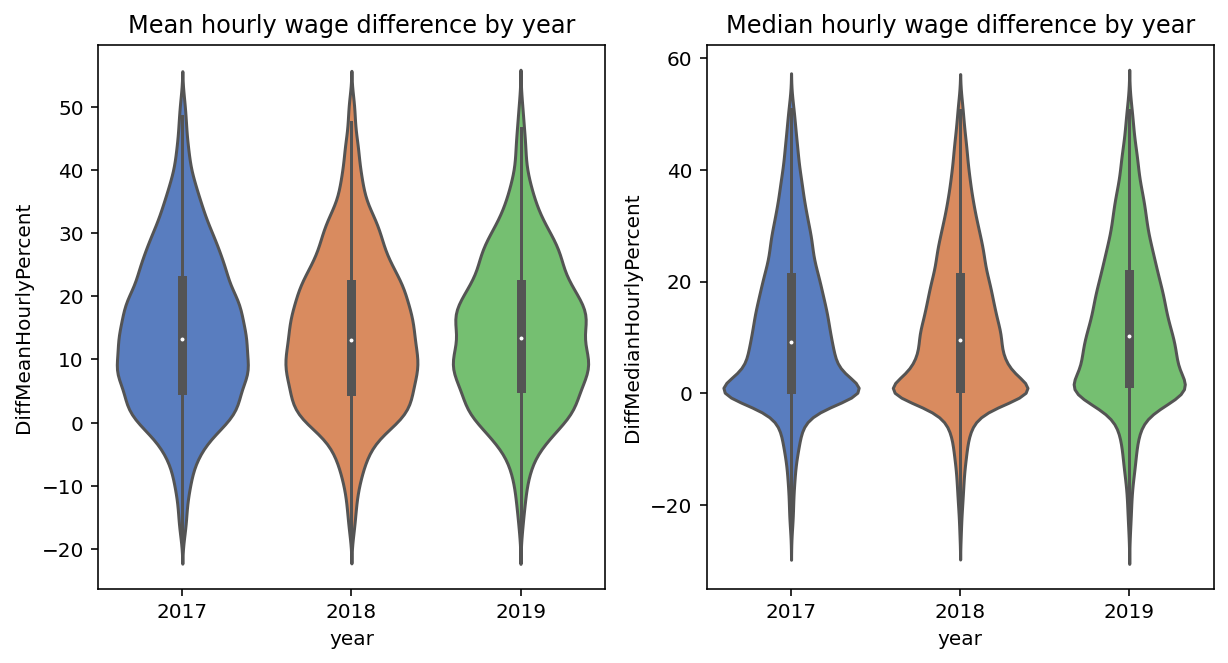

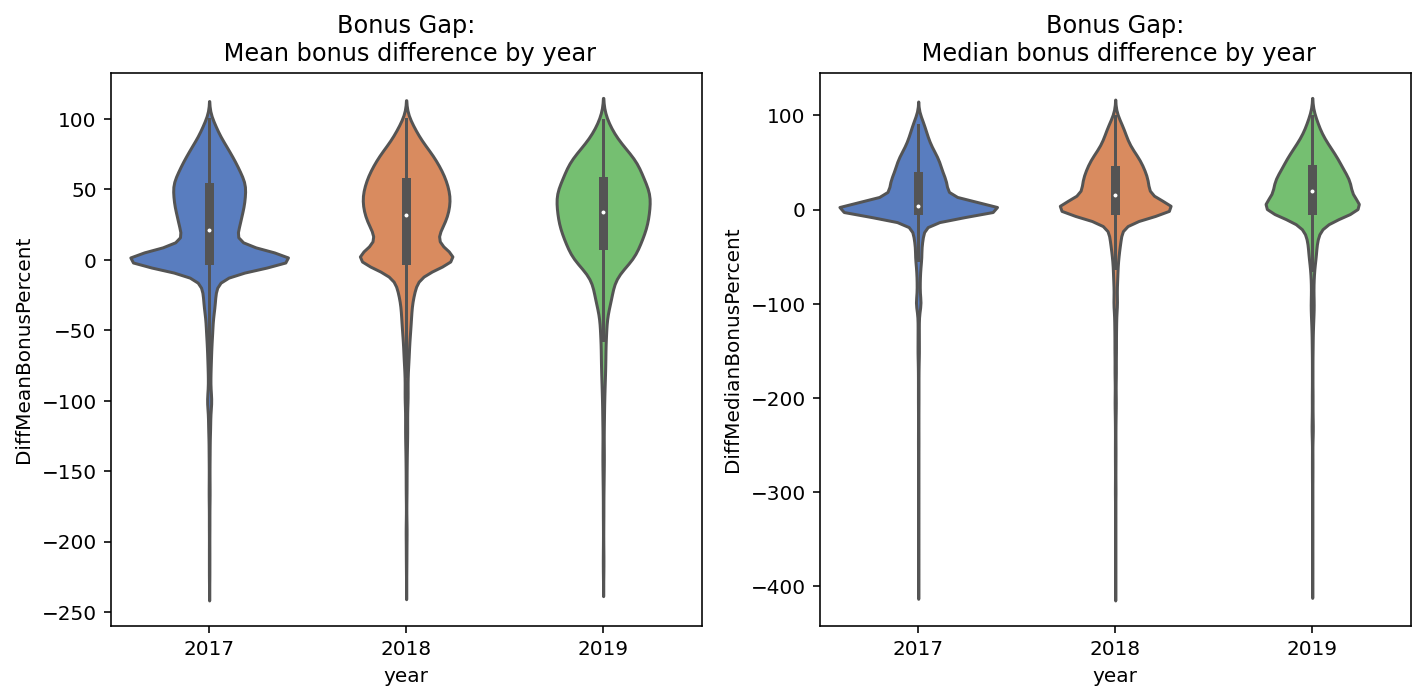

In [5]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
sns.violinplot(ax=ax[0], y="DiffMeanHourlyPercent", x="year", 
                    data=df_mean_hourly_filtered, palette="muted")
ax[0].set_title('Mean hourly wage difference by year')
sns.violinplot(ax=ax[1], y="DiffMedianHourlyPercent", x="year", 
                    data=df_median_hourly_filtered, palette="muted")
ax[1].set_title('Median hourly wage difference by year')

fig,ax = plt.subplots(1,2, figsize=(10,5))
sns.violinplot(ax=ax[0], y="DiffMeanBonusPercent", x="year", 
                    data=df_bonus_filtered, palette="muted")
ax[0].set_title('Bonus Gap:\n Mean bonus difference by year')
sns.violinplot(ax=ax[1], y="DiffMedianBonusPercent", x="year", 
                    data=df_mbonus_filtered, palette="muted")
ax[1].set_title('Bonus Gap:\n Median bonus difference by year')
plt.tight_layout()

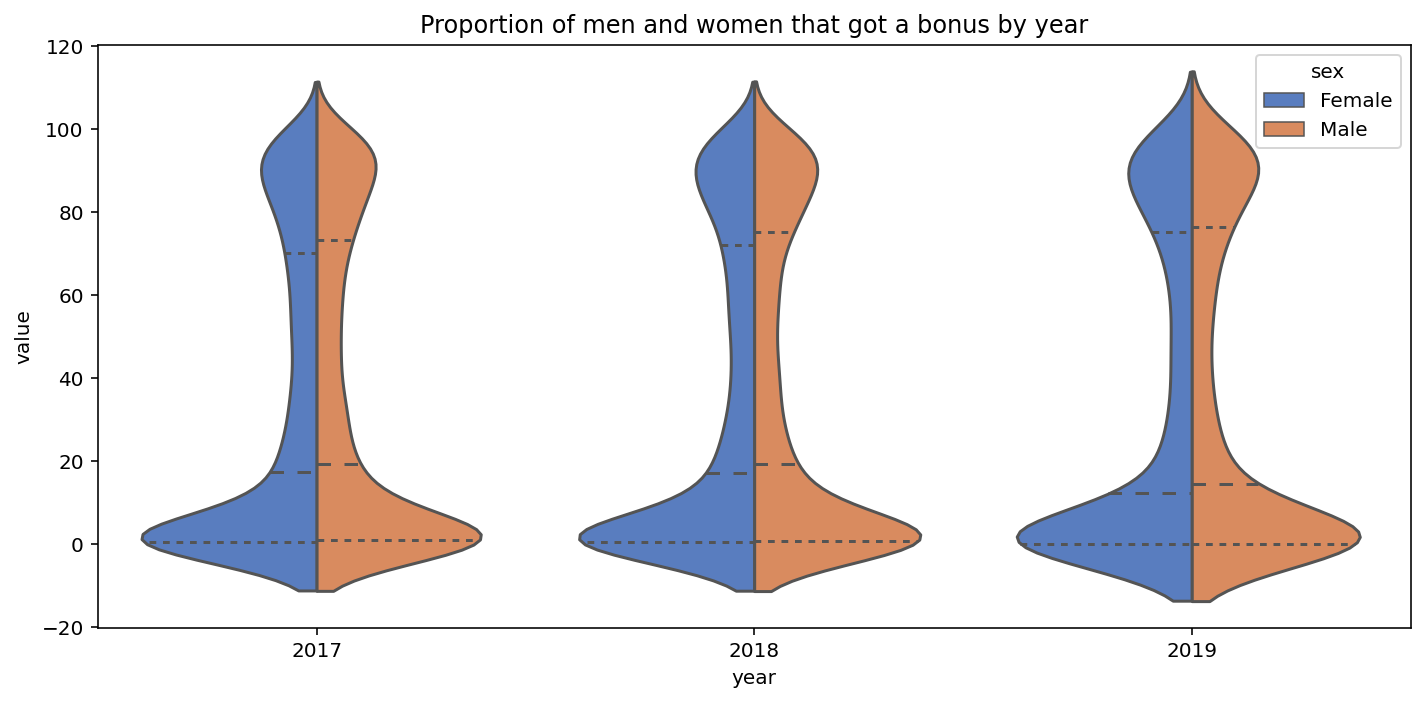

In [6]:
df2 = df[['CurrentName','year', 'FemaleBonusPercent', 'MaleBonusPercent']].melt(id_vars =['CurrentName', 'year'])
df2['sex'] = df2['variable'].map(lambda x: 'Male' if x == 'MaleBonusPercent' else 'Female')
del df2['variable']
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.violinplot(ax=ax, y="value", x="year", split=True, hue='sex', 
                     data=df2, palette="muted", inner='quartile')
ax.set_title('Proportion of men and women that got a bonus by year')

plt.tight_layout()

In [7]:
df2[['sex', 'value']].tail(100)

,sex,value
52150,Male,4.800000
52151,Male,34.500000
52152,Male,84.699997
52153,Male,0.000000
52154,Male,98.000000
...,...,...
52245,Male,94.300003
52246,Male,11.700000
52247,Male,48.500000
52248,Male,49.799999


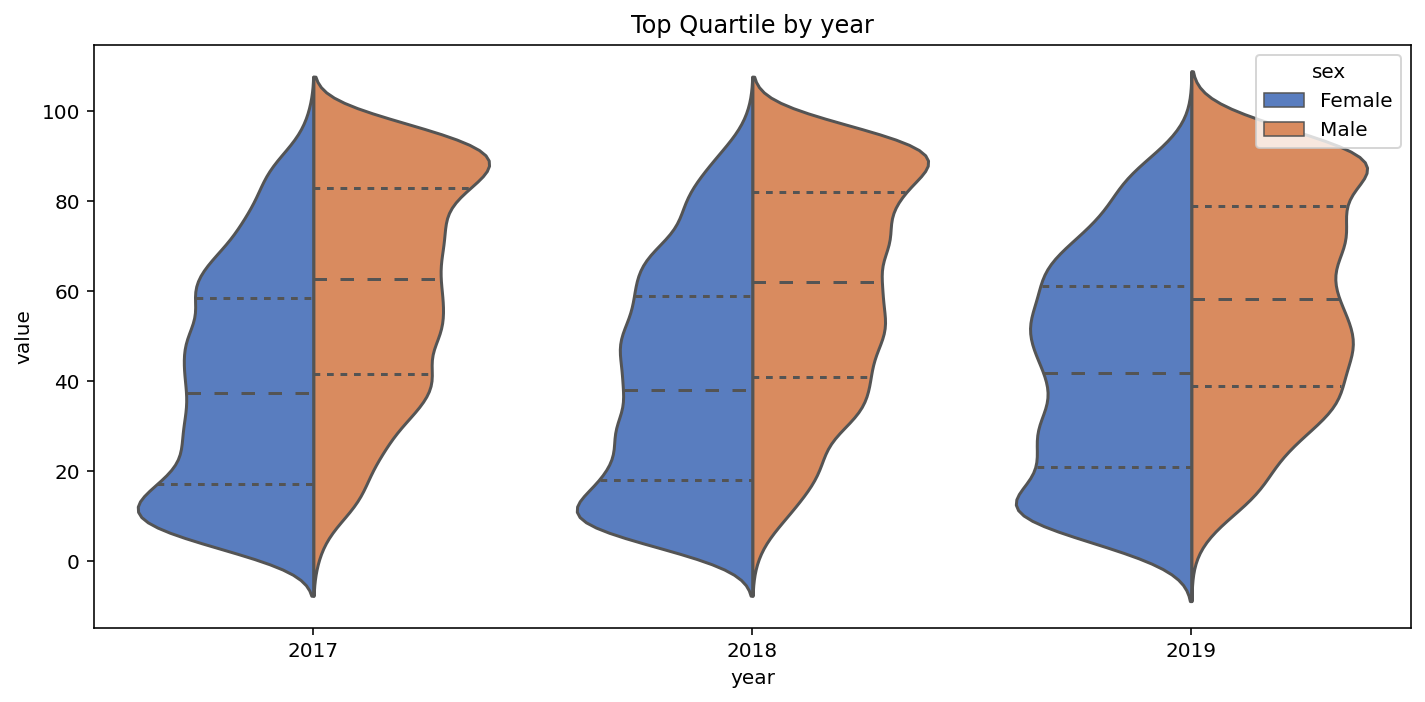

In [8]:
df2 = df[['CurrentName','year', 'FemaleTopQuartile', 'MaleTopQuartile']].melt(id_vars =['CurrentName', 'year'])
df2['sex'] = df2['variable'].map(lambda x: 'Male' if x == 'MaleTopQuartile' else 'Female')
del df2['variable']
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.violinplot(ax=ax, y="value", x="year", split=True, hue='sex', 
                     data=df2, palette="muted",inner='quartile')
ax.set_title('Top Quartile by year')
plt.tight_layout()

In [19]:
df['MalePerc'] = 0.25 * (df.MaleLowerQuartile + df.MaleLowerMiddleQuartile + df.MaleUpperMiddleQuartile + df.MaleTopQuartile)
df['FemalePerc']= 0.25 * (df.FemaleLowerQuartile + df.FemaleLowerMiddleQuartile + df.FemaleUpperMiddleQuartile +df.FemaleTopQuartile)
df['GenderSkew'] = df['MalePerc'] - df['FemalePerc']

Text(0.5, 1.0, 'Ranked imbalance employee gender (all companies, 2018)')

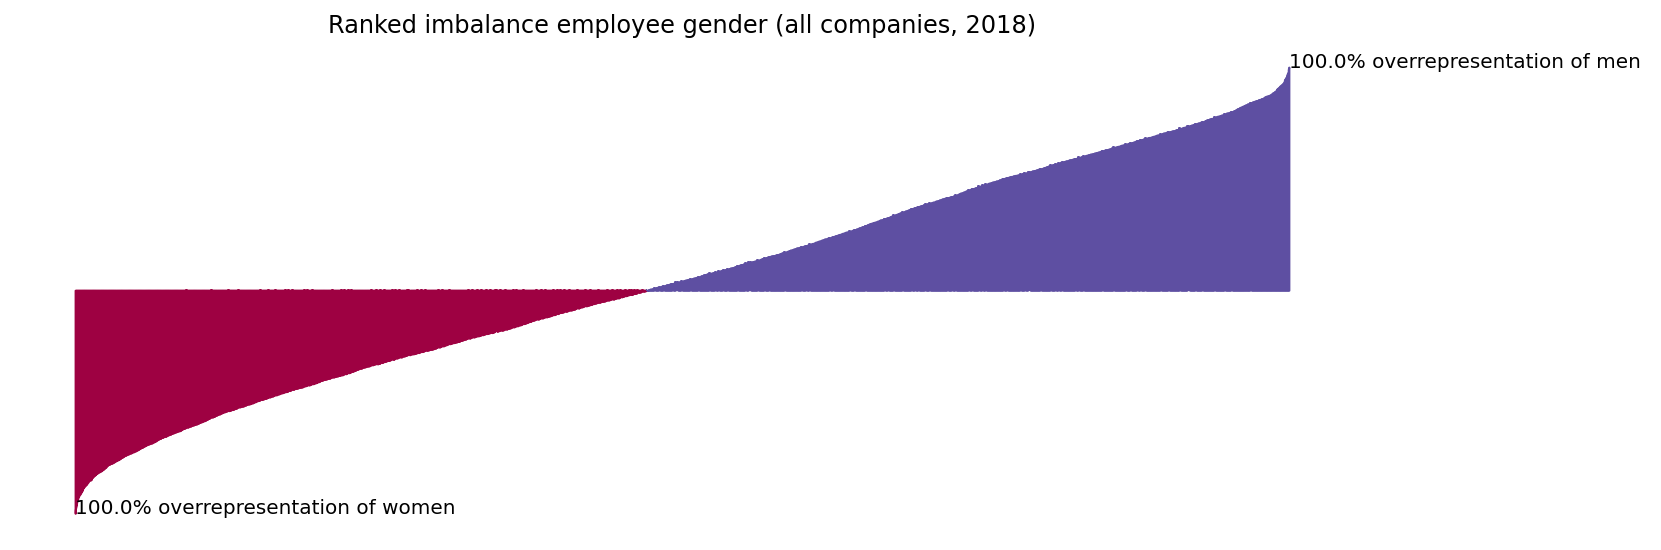

In [20]:

fig, ax = plt.subplots(1,1,figsize=(10,4))
plt.tight_layout()
fig.patch.set_visible(False)
cmap = plt.cm.Spectral
y = df[df['year'] == year]['GenderSkew'].sort_values().values
NUM_POINTS = len(y)
x = np.arange(NUM_POINTS)

normalize = colors.Normalize(vmin=min(y), vmax=max(y))
# plt.plot( x,y, 'k',label=str(year), lw=2)
ax.axis('off')

# Select a color map

STEP_SIZE=10
for i in range(0, NUM_POINTS-1, STEP_SIZE):
    ax.fill_between(x[i:i+STEP_SIZE], y[i:i+ STEP_SIZE], color=cmap(-1. if y[i] <0 else 1.))
ax.annotate(xy=(0, y[0]),s='{:.1f}% overrepresentation of women'.format(-y[0]) )
ax.annotate(xy=(x[-1], y[-1]),s='{:.1f}% overrepresentation of men '.format(y[-1]) )
ax.set_title('Ranked imbalance employee gender (all companies, 2018)')    


Text(0.5, 0.98, 'Ranked imbalance in pay quartiles, corrected for company gender balance (all companies, 2018)')

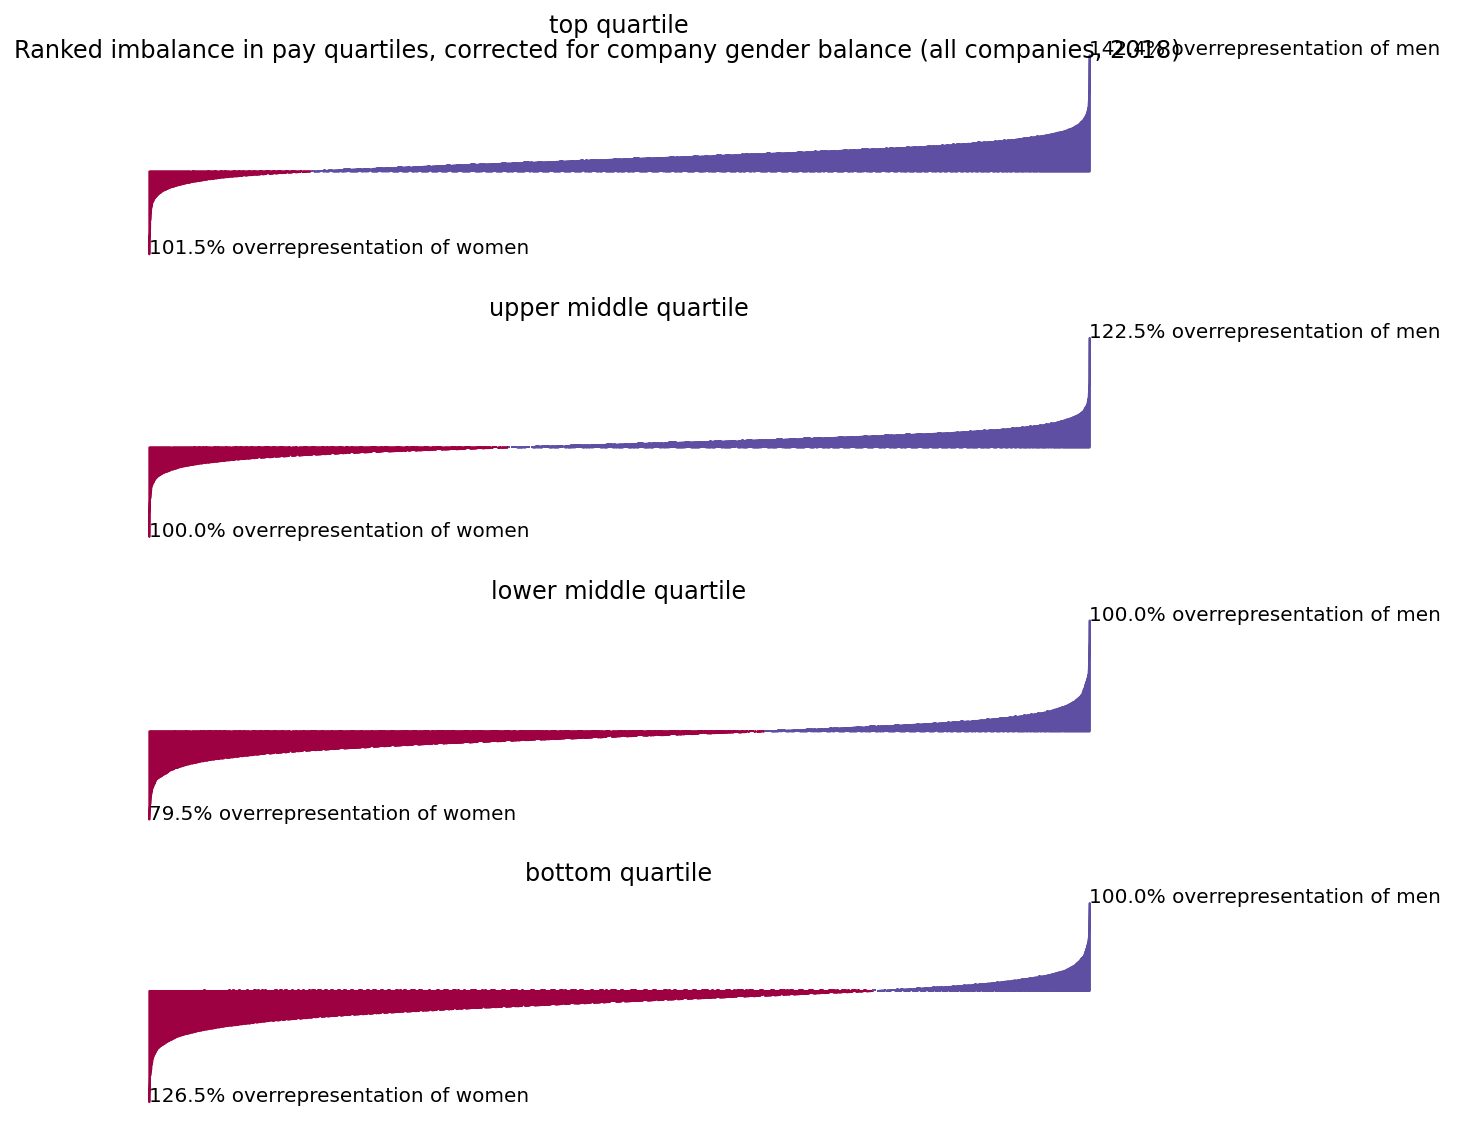

In [35]:
year= 2018


df['q1'] = (df.MaleLowerQuartile - df.FemaleLowerQuartile) - df.GenderSkew
df['q2'] = (df.MaleLowerMiddleQuartile - df.FemaleLowerMiddleQuartile) - df.GenderSkew
df['q3'] = (df.MaleUpperMiddleQuartile - df.FemaleUpperMiddleQuartile) - df.GenderSkew
df['q4'] = (df.MaleTopQuartile - df.FemaleTopQuartile) - df.GenderSkew

fig, axs = plt.subplots(4,1,figsize=(8,8))
plt.tight_layout()
fig.patch.set_visible(False)
cmap = plt.cm.Spectral

for idx, metric_and_descr in enumerate((('q4', 'top'), ('q3','upper middle'), ('q2','lower middle'),('q1', 'bottom'))):
    metric, description = metric_and_descr
    ax = axs[idx]
    y = df[df['year'] == year][metric].sort_values().values
    NUM_POINTS = len(y)
    x = np.arange(NUM_POINTS)

    normalize = colors.Normalize(vmin=min(y), vmax=max(y))
    # plt.plot( x,y, 'k',label=str(year), lw=2)
    ax.axis('off')

    # Select a color map

    STEP_SIZE=10
    for i in range(0, NUM_POINTS-1, STEP_SIZE):
        ax.fill_between(x[i:i+STEP_SIZE], y[i:i+ STEP_SIZE], color=cmap(-1. if y[i] <0 else 1.))
    ax.annotate(xy=(0, y[0]),s='{:.1f}% overrepresentation of women'.format(-y[0]) )
    ax.annotate(xy=(x[-1], y[-1]),s='{:.1f}% overrepresentation of men '.format(y[-1]) )
    ax.set_title('{} quartile'.format(description))    
fig.suptitle('Ranked imbalance in pay quartiles, corrected for company gender balance (all companies, 2018)')